# Controllers

This notebook will demonstrate the basic workflow for controllers.

## Set-Up

First we will import AutoMPC and generate our system identification dataset as before.

In [1]:
import autompc as ampc
import numpy as np
from autompc.benchmarks import CartpoleSwingupBenchmark

benchmark = CartpoleSwingupBenchmark()

system = benchmark.system
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

Loading AutoMPC...
Finished loading AutoMPC


Next, we will create a System ID model to be used by the controller.  Here, we will use the SINDy model.

In [2]:
from autompc.sysid import SINDy

model = SINDy(system)
model.set_hyper_values(trig_basis=True, trig_interaction=True)
model.train(trajs)

## Creating the Control Problem (OCP)

To create a controller, we first need to define the optimal control problem (OCP).  The OCP specifies an objective function and a set of constraints.

We'll start out by defining the objective function, which will be a quadratic cost.  Here we'll manually set some values for the cost matrices which have been shown in the past to work well, but in the future we'll learn how to choose these automatically via tuning (see [TODO] for details).

In [3]:
from autompc.costs import QuadCost

Q = np.diag([0.01, 0.001, 0.001, 150.0])
R = np.diag([0.001])
F = np.diag([1000, 100, 0.001, 30])
cost = QuadCost(system, Q, R, F, goal=np.zeros(4))

Now, we create the OCP and associate it with hte cost we just created.  We'll also add constraints in the form of control bounds.  AutoMPC doesn't currently support more complex constraints than this, but we're hoping to add to support for these in the future!

In [4]:
from autompc.ocp import OCP

ocp = OCP(system)
ocp.set_cost(cost)
ocp.set_ctrl_bound("u", -20.0, 20.0)

## Controller

Now, we can create the controller!  We 

In [5]:
controller = ampc.Controller(system)

To use the controller, there are a few things we need to set up.  First, let's set the optimizer.  Here will use IterativeLQR with a horizon of 20.

In [6]:
from autompc.optim import IterativeLQR

controller.set_optimizer(IterativeLQR(system))
controller.set_optimizer_hyper_values(horizon=20)

Next, we will set the controller to use the system ID model.

In [7]:
controller.set_model(model)

Next, we will provide the controller with the OCP we created early.

In [8]:
controller.set_ocp(ocp)

Finally, we need to call `build()` to get the controller ready to use.

In [9]:
controller.get_config_space()

Configuration space object:
  Hyperparameters:
    IterativeLQR:horizon, Type: UniformInteger, Range: [5, 25], Default: 20
    SINDy:poly_basis, Type: Categorical, Choices: {true, false}, Default: false
    SINDy:poly_cross_terms, Type: Categorical, Choices: {false}, Default: false
    SINDy:poly_degree, Type: UniformInteger, Range: [2, 8], Default: 3
    SINDy:threshold, Type: UniformFloat, Range: [1e-05, 10.0], Default: 0.01, on log-scale
    SINDy:time_mode, Type: Categorical, Choices: {discrete, continuous}, Default: discrete
    SINDy:trig_basis, Type: Categorical, Choices: {true, false}, Default: false
    SINDy:trig_freq, Type: UniformInteger, Range: [1, 8], Default: 1
    SINDy:trig_interaction, Type: Categorical, Choices: {false}, Default: false
    model, Type: Categorical, Choices: {SINDy}, Default: SINDy
    ocp_factory, Type: Categorical, Choices: {Identity}, Default: Identity
    optimizer, Type: Categorical, Choices: {IterativeLQR}, Default: IterativeLQR
  Conditions:
  

In [10]:
controller.build()

We can now use the controller!  This is done by calling the `step` method with the most recent observation.

In [11]:
current_obs = np.array([np.pi, 0.0, 0.0, 0.0])
u = controller.step(current_obs)
u

array([-20.])

We note that the controller tracks state for both the optimizer and the model.  This means calling the controller for the same observation may not yield the same result.

We can always reset to the initial state by calling `reset()`, or explicitly manage the state using the `set_state()` and `get_state()` methods.

By repeatedly calling run, we can simulate the behavior of the controller. To make this easier, we provide the simulate function.

In [12]:
traj = ampc.simulate(controller, init_obs=np.array([np.pi, 0.0, 0.0, 0.0]), max_steps=200, dynamics=benchmark.dynamics)

100%|██████████| 200/200 [01:00<00:00,  3.28it/s]


We can the visualize the resulting trajectory

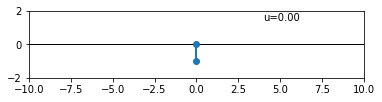

In [13]:
import matplotlib.pyplot as plt
from IPython.display import HTML

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, traj)
HTML(anim.to_html5_video())

## Changing the Control Problem

We can set the controller to solve a new control problem with requiring a rebuild.  As an example, let's change our target state to have a positive velocity of 0.5 in the x-axis.

In [14]:
cost2 = QuadCost(system, Q, R, F, goal=np.array([0.0, 0.0, 0.0, 0.5]))
ocp2 = ocp.clone()
ocp2.set_cost(cost2)

controller.set_ocp(ocp2)
controller.reset()

Let's now simulate and visualize the results of the controller with the new ocp.

100%|██████████| 200/200 [00:54<00:00,  3.67it/s]


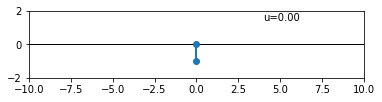

In [15]:
traj2 = ampc.simulate(controller, init_obs=np.array([np.pi, 0.0, 0.0, 0.0]), max_steps=200, dynamics=benchmark.dynamics)

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, traj2)
HTML(anim.to_html5_video())